In [1]:
import os
import time
#import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
#%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, draw, show
from tensorflow import keras
from PIL import Image

C:\users\justin\appdata\local\programs\python\python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\users\justin\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\users\justin\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
img_height, img_width = 256, 256
batch_size = 128

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'C:/Users/Justin/Git_geteilt/images/Gutteile',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=None)

Found 1050 files belonging to 1 classes.


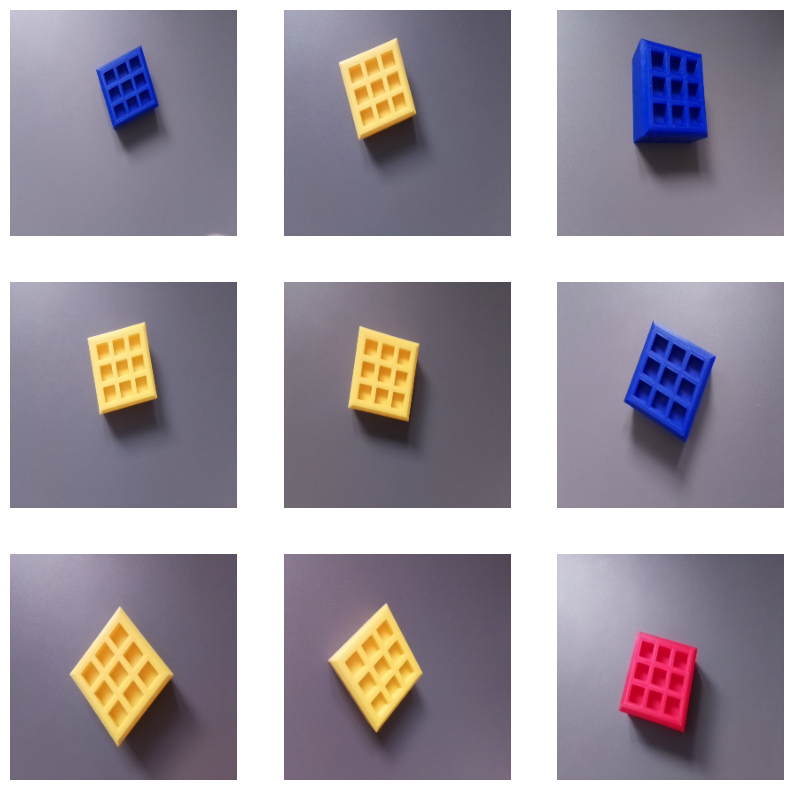

In [4]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        draw()

In [5]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)

In [6]:
normalized_ds = train_ds.map(lambda x: normalization_layer(x))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [7]:
print(np.min(first_image), np.max(first_image)) 

0.0 0.88817406


In [8]:
input_encoder = (256, 256, 3)
input_decoder = (200,)

In [9]:
def encoder(input_encoder):
    
    
    inputs = keras.Input(shape=input_encoder, name='input_layer')
    x = layers.Conv2D(32, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
    
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
    
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
    
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_5')(x)
    x = layers.BatchNormalization(name='bn_5')(x)
    x = layers.LeakyReLU(name='lrelu_5')(x)
   
    
    flatten = layers.Flatten()(x)
    bottleneck = layers.Dense(200, name='dense_1')(flatten)
    model = tf.keras.Model(inputs, bottleneck, name="Encoder")
    return model

In [10]:
enc = encoder(input_encoder)

enc.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 bn_1 (BatchNormalization)   (None, 128, 128, 32)      128       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 128, 128, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 64, 64, 64)        18496     
                                                                 
 bn_2 (BatchNormalization)   (None, 64, 64, 64)        256       
                                                                 
 lrelu_2 (LeakyReLU)         (None, 64, 64, 64)        0   

In [11]:
def decoder(input_decoder):
    
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(4096, name='dense_1')(inputs)
    #x = tf.reshape(x, [-1, 8, 8, 64], name='Reshape_Layer')
    x = layers.Reshape((8,8,64), name='Reshape_Layer')(x)
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
  
    
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
   
    
    x = layers.Conv2DTranspose(64, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
  
    
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
   
  
    
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model

In [12]:
dec = decoder(input_decoder)

dec.summary()

#dec.save('ae-cartoon-dec.h5')

#model.layers[1].get_weights()

#model.save('autoencoder.h5')

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              823296    
                                                                 
 Reshape_Layer (Reshape)     (None, 8, 8, 64)          0         
                                                                 
 conv_transpose_1 (Conv2DTra  (None, 16, 16, 64)       36928     
 nspose)                                                         
                                                                 
 bn_1 (BatchNormalization)   (None, 16, 16, 64)        256       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 16, 16, 64)        0         
                                                           

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)

In [14]:
def ae_loss(y_true, y_pred):
    #loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    #loss = tf.reduce_mean(tf.square(tf.subtract(y_true, y_pred)))
    loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return loss

In [15]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
@tf.autograph.experimental.do_not_convert
def train_step(images):

    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
      
        latent = enc(images, training=True)
        generated_images = dec(latent, training=True)
        loss = ae_loss(images, generated_images)
        
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
    

    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))
    return loss

In [16]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        i = 0
        loss_ = []
        for image_batch in dataset:
            i += 1
            loss = train_step(image_batch)
            loss_.append(loss)
        
        print(loss_)
        # print("Loss",np.mean(loss_))    
        seed = image_batch[:25]
        display.clear_output(wait=True)
        generate_and_save_images([enc,dec],
                                  epoch + 1,
                                  seed)
        # Save the model every 15 epochs
        #if (epoch + 1) % 15 == 0:
        #checkpoint.save(file_prefix = checkpoint_prefix)
        enc.save_weights('C:/Users/Justin/Git_geteilt/Pytorch_Anomalie_Detection/Autoencoder-in-TensorFlow/tf_ae/blocks/training_weights/enc_'+ str(epoch)+'.h5')
        dec.save_weights('C:/Users/Justin/Git_geteilt/Pytorch_Anomalie_Detection/Autoencoder-in-TensorFlow/tf_ae/blocks/training_weights/dec_'+ str(epoch)+'.h5')
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images([enc,dec],
                            epochs,
                            seed)

In [17]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    latent = enc(test_input, training=False)
    predictions = dec(latent, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        pred = predictions[i, :, :, :] * 255
        pred = np.array(pred)  
        pred = pred.astype(np.uint8)
        #cv2.imwrite('tf_ae/images/image'+ str(i)+'.png',pred)
        plt.imshow(pred)
        plt.axis('off')

    plt.savefig('C:/Users/Justin/Git_geteilt/Pytorch_Anomalie_Detection/Autoencoder-in-TensorFlow/tf_ae/blocks/images/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

(25, 256, 256, 3)


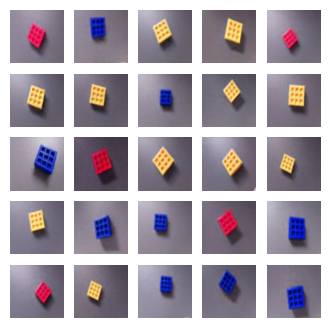

In [19]:
train(normalized_ds, 200)

In [21]:
enc.load_weights('C:/Users/Justin/Git_geteilt/Pytorch_Anomalie_Detection/Autoencoder-in-TensorFlow/tf_ae/blocks/training_weights/enc_199.h5')

dec.load_weights('C:/Users/Justin/Git_geteilt/Pytorch_Anomalie_Detection/Autoencoder-in-TensorFlow/tf_ae/blocks/training_weights/dec_199.h5')

In [22]:
embeddings = None
for i in normalized_ds:
    latent = enc.predict(i)
    if embeddings is None:
        embeddings = latent
    else:
        embeddings = np.concatenate((embeddings, latent))
    if embeddings.shape[0] > 5000:
        break

embeddings.shape

1/1 [==============================] - 0s 406ms/step


(1050, 200)

C:\users\justin\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\users\justin\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


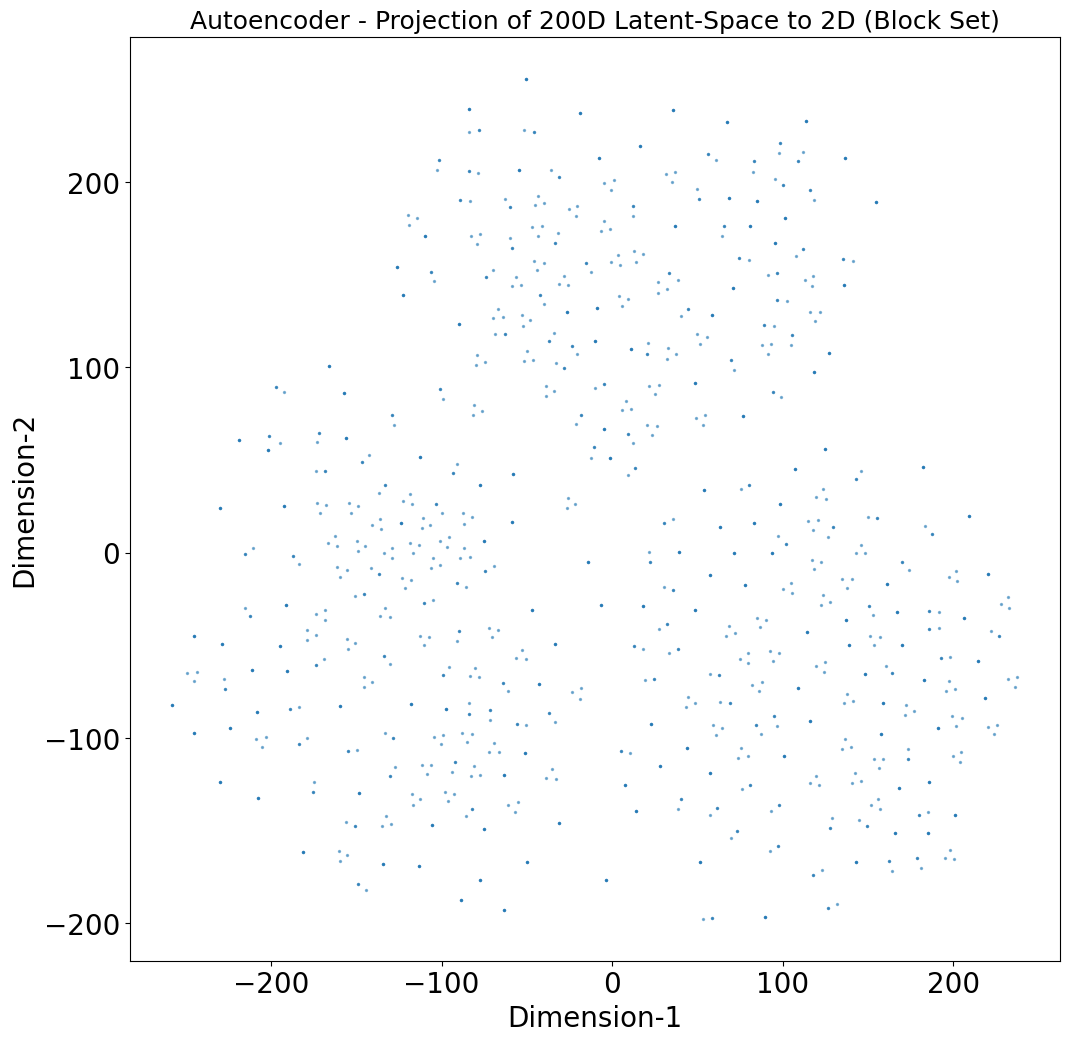

In [23]:
n_to_show = 5000
grid_size = 15
figsize = 12

tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(embeddings)
min_x = min(X_tsne[:, 0])
max_x = max(X_tsne[:, 0])
min_y = min(X_tsne[:, 1])
max_y = max(X_tsne[:, 1])


plt.figure(figsize=(figsize, figsize))
plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Autoencoder - Projection of 200D Latent-Space to 2D (Block Set)", size=18)
draw()
plt.show()

In [24]:
reconstruction = None
lat_space = None
for i in normalized_ds:
    latent= enc.predict(i)
    out = dec.predict(latent)
    if reconstruction is None:
        reconstruction = out
        lat_space = latent
    else:
        reconstruction = np.concatenate((reconstruction, out))
        lat_space = np.concatenate((lat_space, latent))
    if reconstruction.shape[0] > 5000:
        break
    
reconstruction.shape

1/1 [==============================] - 0s 466ms/step


(1050, 256, 256, 3)

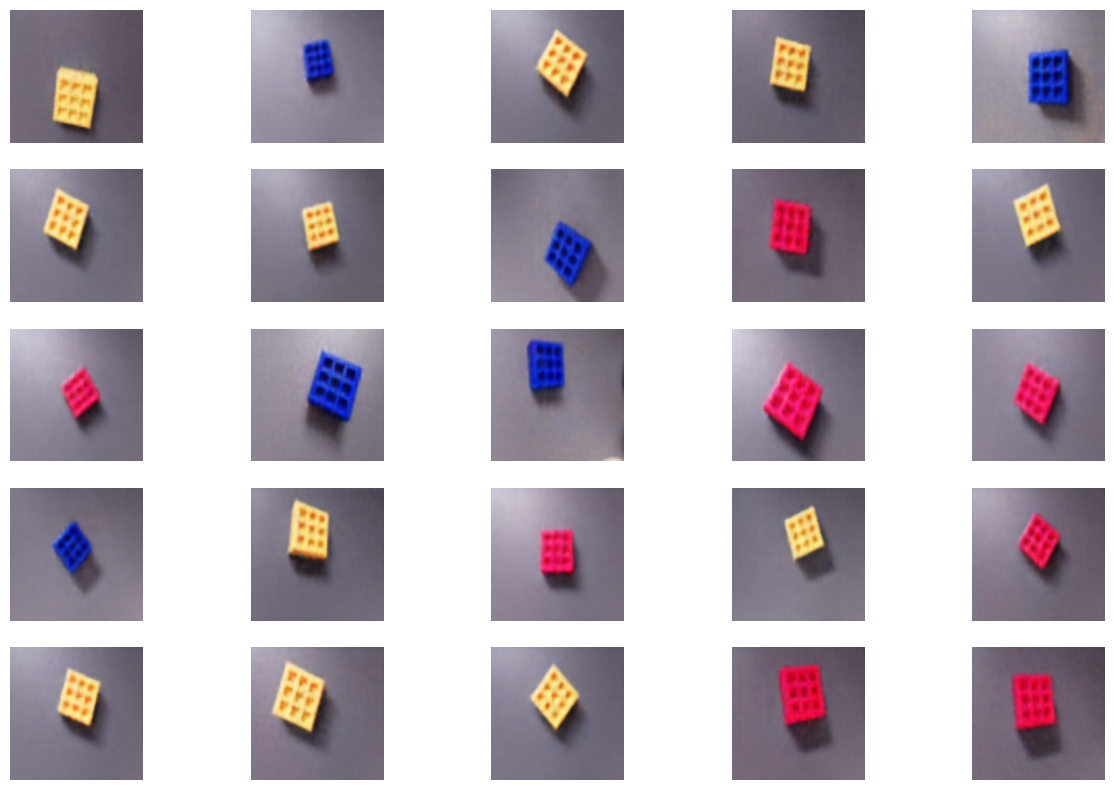

In [25]:
figsize = 15

fig = plt.figure(figsize=(figsize, 10))
#fig.subplots_adjust(hspace=0.2, wspace=None)

for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruction[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

(10, 200)
1/1 [==============================] - 0s 135ms/step


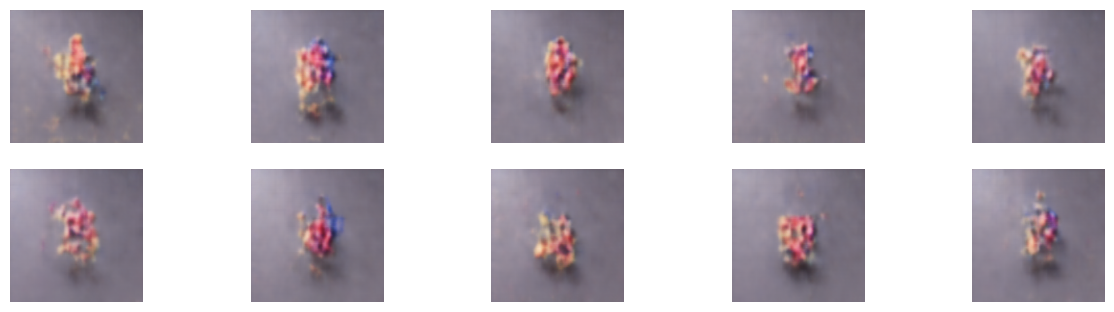

In [26]:
figsize = 15

min_x = lat_space.min(axis=0)
max_x = lat_space.max(axis=0)
# #print(max_x.shape, min_x.shape)
x = np.random.uniform(size = (10,200))
x = x * (max_x - (np.abs(min_x))) 
print(x.shape)
#x = np.random.normal(size = (10,200))
reconstruct = dec.predict(x)


fig = plt.figure(figsize=(figsize, 10))

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

1/1 [==============================] - 0s 121ms/step


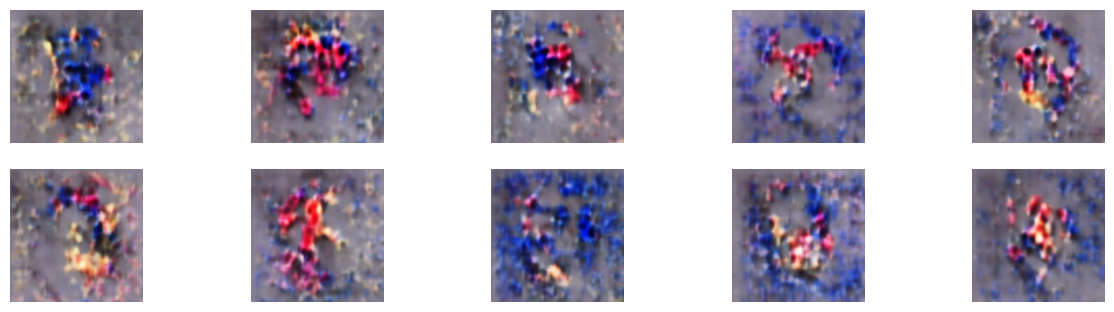

In [27]:
x = np.random.normal(size = (10,200))
reconstruct = dec.predict(x)

fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(10):
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    pred = reconstruct[i, :, :, :] * 255
    pred = np.array(pred)  
    pred = pred.astype(np.uint8)
    ax.imshow(pred)

In [28]:
loss_ = []

for batch in normalized_ds:
    loss = train_step(batch)
    loss_.append(loss)

In [29]:
print(loss_)

[<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([0.00051889, 0.00060762, 0.00054588, 0.00063771, 0.00065265,
       0.00052664, 0.00072752, 0.00056807, 0.00063589, 0.00074914,
       0.00079623, 0.00045623, 0.00057977, 0.00072812, 0.00072752,
       0.00077809, 0.00071296, 0.00051315, 0.0005368 , 0.00052605,
       0.00052498, 0.00073109, 0.00076276, 0.00050301, 0.00089315,
       0.00071246, 0.00057215, 0.00070038, 0.0006836 , 0.00049636,
       0.00051199, 0.00072752, 0.00064967, 0.00045623, 0.00048472,
       0.00070163, 0.00047138, 0.00064245, 0.0008449 , 0.00052605,
       0.00073257, 0.00058594, 0.0005864 , 0.00065134, 0.00055097,
       0.00050589, 0.00050301, 0.00091009, 0.000619  , 0.00058431,
       0.0007802 , 0.0005852 , 0.00055252, 0.00058781, 0.00053623,
       0.00052341, 0.00056919, 0.00072271, 0.00049558, 0.00068895,
       0.00061757, 0.00059249, 0.00076618, 0.00067891, 0.00058218,
       0.00082198, 0.00066749, 0.00056614, 0.00061993, 0.00057648,
       0.0005

In [30]:
prediction_ = []
for i in range(len(loss_)):
    prediction = loss_[i] < 0.002
    prediction_.append(prediction)
print(prediction_)

[<tf.Tensor: shape=(128,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  T

In [31]:
# to save the weights of the decoder-model:
    
dec.save_weights('saved_weights_dec')
enc.save_weights('saved_weights_enc')

# to load the the entire model, see "load_decoder_model"

In [32]:
# Settings
models_path_dec = 'C:/Users/Justin/Git_geteilt'
keras_model_name_dec = 'block_model_dec200'           # Will be given .h5 suffix
tflite_model_name_dec = 'block_model_dec200'          # Will be given .tflite suffix
c_model_name_dec = 'block_model_dec200'               # Will be given .h suffix1

models_path_enc = 'C:/Users/Justin/Git_geteilt'
keras_model_name_enc = 'block_model_enc200'           # Will be given .h5 suffix
tflite_model_name_enc = 'block_model_enc200'          # Will be given .tflite suffix
c_model_name_enc = 'block_model_enc200'               # Will be given .h suffix1

In [33]:
converter_dec = tf.lite.TFLiteConverter.from_keras_model(dec)
converter_enc = tf.lite.TFLiteConverter.from_keras_model(enc)

In [34]:
tflite_dec = converter_dec.convert()
tflite_enc = converter_enc.convert()

open('/'.join((models_path_dec, tflite_model_name_dec)) + '.h5', 'wb').write(tflite_dec)
open('/'.join((models_path_enc, tflite_model_name_enc)) + '.h5', 'wb').write(tflite_enc)

INFO:tensorflow:Assets written to: C:\Users\Justin\AppData\Local\Temp\tmp55u45jz4\assets


INFO:tensorflow:Assets written to: C:\Users\Justin\AppData\Local\Temp\tmp55u45jz4\assets


INFO:tensorflow:Assets written to: C:\Users\Justin\AppData\Local\Temp\tmpccvrebet\assets


INFO:tensorflow:Assets written to: C:\Users\Justin\AppData\Local\Temp\tmpccvrebet\assets


3802208

In [6]:
TFLITE_FILE_PATH_dec = '/'.join((models_path_dec, tflite_model_name_dec)) + '.tflite'
dec_int =  tf.lite.Interpreter(TFLITE_FILE_PATH_dec)
dec_sign = dec_int.get_signature_runner()

TFLITE_FILE_PATH_enc = '/'.join((models_path_enc, tflite_model_name_enc)) + '.tflite'
enc_int =  tf.lite.Interpreter(TFLITE_FILE_PATH_enc)
enc_sign = enc_int.get_signature_runner()

In [7]:
enc_sign

In [34]:
TFLITE_FILE_PATH_enc = '/'.join((models_path_enc, tflite_model_name_enc)) + '.tflite'
enc_int =  tf.lite.Interpreter(model_path=TFLITE_FILE_PATH_enc)
enc_int.allocate_tensors()

input_details = enc_int.get_input_details()
output_details = enc_int.get_output_details()

input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
enc_int.set_tensor(input_details[0]['index'], input_data)

enc_int.invoke()

output_data = enc_int.get_tensor(output_details[0]['index'])
print(output_data.shape)
print(input_shape)



(1, 200)
[  1 256 256   3]


In [37]:
TFLITE_FILE_PATH_dec = '/'.join((models_path_dec, tflite_model_name_dec)) + '.tflite'
dec_int =  tf.lite.Interpreter(model_path=TFLITE_FILE_PATH_dec)
dec_int.allocate_tensors()

input_details = dec_int.get_input_details()
output_details = dec_int.get_output_details()

input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
dec_int.set_tensor(input_details[0]['index'], input_data)

dec_int.invoke()

output_data = dec_int.get_tensor(output_details[0]['index'])
print(output_data.shape)
print(input_shape)

(1, 256, 256, 3)
[  1 200]


In [35]:
input_details[0]['index']

0

In [43]:
enc_int

In [122]:
image = Image.open('C:/Users/Justin/Git_geteilt/images/Gutteile/opencv_frame_8.png')

image = image.resize((256, 256))



# image.show()

image = np.asarray(image).astype(np.float32)/255

print(image.shape)

TFLITE_FILE_PATH_enc = '/'.join((models_path_enc, tflite_model_name_enc)) + '.h5'
enc_int =  tf.lite.Interpreter(model_path=TFLITE_FILE_PATH_enc)
enc_int.allocate_tensors()
input_details_enc = enc_int.get_input_details()
output_details_enc = enc_int.get_output_details()
input_data_enc = np.array(image, dtype=np.float32)
enc_int.set_tensor(input_details_enc[0]['index'], input_data_enc.reshape(1,256,256,3))
enc_int.invoke()
output_data_enc = enc_int.get_tensor(output_details_enc[0]['index'])

TFLITE_FILE_PATH_dec = '/'.join((models_path_dec, tflite_model_name_dec)) + '.h5'
dec_int =  tf.lite.Interpreter(model_path=TFLITE_FILE_PATH_dec)
dec_int.allocate_tensors()
input_details_dec = dec_int.get_input_details()
output_details_dec = dec_int.get_output_details()
input_data_dec = np.array(output_data_enc, dtype=np.float32)
dec_int.set_tensor(input_details_dec[0]['index'], input_data_dec)
dec_int.invoke()
output_data = dec_int.get_tensor(output_details_dec[0]['index'])

# output_data_enc = (np.amax(output_data_enc)-np.amin(output_data_enc))

#gen_image = Image.fromarray(output_data)
#gen_image.show()


(256, 256, 3)


In [123]:
image.shape

(256, 256, 3)

In [117]:
output_data1 = output_data[0,:,:,:]
gen_image = Image.fromarray(np.uint8(output_data1*255))

gen_image.show()

# loss = ae_loss(asarray(image.resize((256,256))),np.array(output_data[0,:,:,:]*256,dtype='int32'))

In [126]:
dect_image = image

dect_gen_image = output_data[0,:,:,:]
                          
print(np.mean(np.square(dect_image-dect_gen_image)))

0.00047603206


In [125]:
output_data.shape

(1, 256, 256, 3)

In [129]:
def im_prediction_loss(filePath):
    models_path_dec = 'C:/Users/Justin/Git_geteilt'
    keras_model_name_dec = 'block_model_dec200'           # Will be given .h5 suffix
    tflite_model_name_dec = 'block_model_dec200'          # Will be given .tflite suffix
    c_model_name_dec = 'block_model_dec200'               # Will be given .h suffix1

    models_path_enc = 'C:/Users/Justin/Git_geteilt'
    keras_model_name_enc = 'block_model_enc200'           # Will be given .h5 suffix
    tflite_model_name_enc = 'block_model_enc200'          # Will be given .tflite suffix
    c_model_name_enc = 'block_model_enc200'               # Will be given .h suffix1

    image = Image.open(filePath)
    image = image.resize((256, 256))
    image = np.asarray(image).astype(np.float32)/255
    
    TFLITE_FILE_PATH_enc = '/'.join((models_path_enc, tflite_model_name_enc)) + '.h5'
    enc_int =  tf.lite.Interpreter(model_path=TFLITE_FILE_PATH_enc)
    enc_int.allocate_tensors()
    input_details_enc = enc_int.get_input_details()
    output_details_enc = enc_int.get_output_details()
    input_data_enc = np.array(image, dtype=np.float32)
    enc_int.set_tensor(input_details_enc[0]['index'], input_data_enc.reshape(1,256,256,3))
    enc_int.invoke()
    output_data_enc = enc_int.get_tensor(output_details_enc[0]['index'])

    TFLITE_FILE_PATH_dec = '/'.join((models_path_dec, tflite_model_name_dec)) + '.h5'
    dec_int =  tf.lite.Interpreter(model_path=TFLITE_FILE_PATH_dec)
    dec_int.allocate_tensors()
    input_details_dec = dec_int.get_input_details()
    output_details_dec = dec_int.get_output_details()
    input_data_dec = np.array(output_data_enc, dtype=np.float32)
    dec_int.set_tensor(input_details_dec[0]['index'], input_data_dec)
    dec_int.invoke()
    output_data = dec_int.get_tensor(output_details_dec[0]['index'])

    output_data1 = output_data[0,:,:,:]
    # Image.fromarray(np.uint8(output_data1*255)).show()
    
    dect_image = image

    dect_gen_image = np.array(output_data[0,:,:,:])

    loss = np.mean(np.square(dect_image-dect_gen_image))
    
    return loss

In [145]:
enc_int

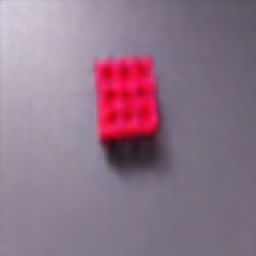

In [113]:
output_data1 = output_data[0,:,:,:]
Image.fromarray(np.uint8(output_data1*255))

In [132]:
%%time
from os import listdir
# C:/Users/Justin/Git_geteilt/images/Gutteile/opencv_frame_8.png
directory = 'C:/Users/Justin/Git_geteilt/images/Gutteile/'
fileList = os.listdir(directory)
predi_ = np.zeros(len(fileList))
for index, file in enumerate(fileList):
    filePath = '/'.join((directory, file))
    predi = im_prediction_loss(filePath)
    predi_[index] = predi
#    print(index)
    
print(min(predi_), max(predi_))
# print(predi)

print(predi_ < 0.0125)



0.00031547038815915585 0.0012569061946123838
[ True  True  True ...  True  True  True]
CPU times: total: 52.9 s
Wall time: 1min 8s


In [143]:
predi_acc = predi_ < 0.00126
predi_acc.sum()

1047

In [131]:
%%time
from os import listdir
# C:/Users/Justin/Git_geteilt/images/Gutteile/opencv_frame_8.png
directory = 'C:/Users/Justin/Git_geteilt/images/Fehler/'
fileList = os.listdir(directory)
predi_ = np.zeros(len(fileList))
for index, file in enumerate(fileList):
    filePath = '/'.join((directory, file))
    predi = im_prediction_loss(filePath)
    predi_[index] = predi
#    print(index)
    
print(min(predi_), max(predi_))
# print(predi)



0.0014073112979531288 0.017428869381546974
CPU times: total: 5.7 s
Wall time: 8.25 s


array([0.27331966, 0.25940008, 0.21700315, 0.18144116, 0.21567083,
       0.21632962, 0.26787139, 0.18837373, 0.17911342, 0.18417473,
       0.18617582, 0.18317891, 0.17996039, 0.30335318, 0.20592155,
       0.20410861, 0.2050262 , 0.20085852, 0.1780592 , 0.18545075,
       0.18904089, 0.18031452, 0.21599147, 0.21703237, 0.29103402,
       0.21077507, 0.20485511, 0.2026663 , 0.20224907, 0.22307571,
       0.23085877, 0.21234568, 0.20132908, 0.28917722, 0.20580477,
       0.21514474, 0.18901968, 0.2151854 , 0.24065286, 0.18664686,
       0.19412011, 0.19324626, 0.26431777, 0.27059852, 0.28451128,
       0.2648536 , 0.26705361, 0.1834392 , 0.2688088 , 0.21137866])

In [10]:
# tf.lite.experimental.Analyzer.analyze(model_content=tflite_dec, gpu_compatibility=False)
# dect_image
np.asarray(image.resize((256,256)))

array([[[203, 190, 203],
        [203, 190, 203],
        [204, 191, 204],
        ...,
        [124, 107, 119],
        [122, 107, 119],
        [122, 105, 119]],

       [[201, 188, 201],
        [204, 191, 203],
        [204, 191, 204],
        ...,
        [126, 109, 122],
        [123, 106, 120],
        [123, 106, 120]],

       [[203, 186, 202],
        [204, 190, 204],
        [204, 191, 204],
        ...,
        [126, 110, 125],
        [126, 108, 126],
        [126, 106, 125]],

       ...,

       [[143, 124, 143],
        [142, 124, 142],
        [141, 126, 143],
        ...,
        [136, 114, 132],
        [135, 115, 132],
        [132, 113, 130]],

       [[144, 125, 142],
        [143, 124, 140],
        [144, 125, 141],
        ...,
        [134, 117, 130],
        [133, 115, 131],
        [131, 113, 130]],

       [[143, 124, 141],
        [144, 125, 142],
        [144, 125, 140],
        ...,
        [133, 116, 130],
        [133, 116, 131],
        [134, 116, 132]]

In [165]:
print(output_data[0,:,:,:].shape)
print(asarray(image.resize((256,256))).shape)

(256, 256, 3)
(256, 256, 3)


PNG
(640, 480)
RGB


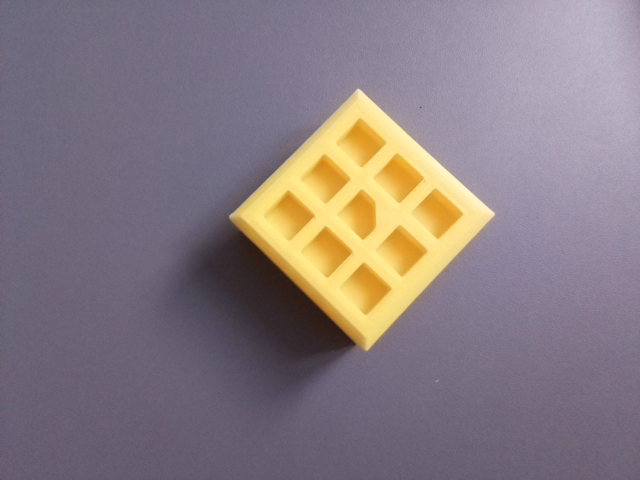

In [110]:
from PIL import Image
# Open the image form working directory
image = Image.open('C:/Users/Justin/Git_geteilt/images/opencv_frame_7.png')
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)
# show the image
# image.show()

image

float32
(480, 640, 3)


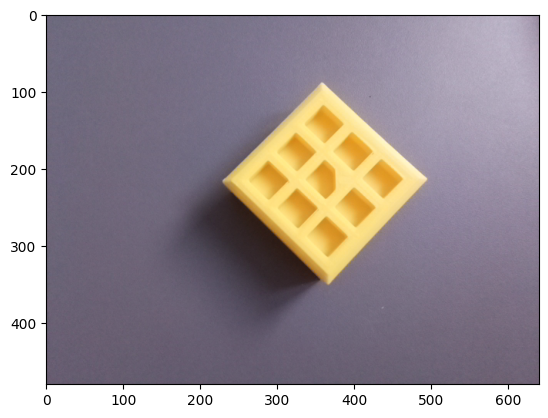

In [87]:
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
image = image.imread('C:/Users/Justin/Git_geteilt/images/opencv_frame_7.png')
# summarize shape of the pixel array
print(image.dtype)
print(image.shape)
# display the array of pixels as an image
pyplot.imshow(image)
pyplot.show()

In [111]:
from PIL import Image
from numpy import asarray
# load the image
image = Image.open('C:/Users/Justin/Git_geteilt/images/opencv_frame_7.png')
# convert image to numpy array
data = asarray(image)
print(data)
# summarize shape
print(data.shape)

# create Pillow image
image2 = Image.fromarray(data)
print(type(image2))

# summarize image details
print(image2.mode)
print(image2.size)

[[[106 102 122]
  [105 101 121]
  [106 104 123]
  ...
  [152 140 159]
  [148 136 155]
  [141 129 148]]

 [[108 104 124]
  [108 104 124]
  [105 103 122]
  ...
  [152 140 159]
  [151 139 158]
  [150 138 157]]

 [[106 102 122]
  [106 102 122]
  [109 105 125]
  ...
  [153 141 160]
  [153 140 161]
  [149 136 157]]

 ...

 [[100  92 111]
  [101  93 112]
  [101  91 111]
  ...
  [110  96 116]
  [112 100 119]
  [109  97 116]]

 [[ 98  88 108]
  [ 99  89 109]
  [100  90 110]
  ...
  [106  94 113]
  [107  95 114]
  [109  97 116]]

 [[ 94  84 104]
  [ 98  88 108]
  [100  90 110]
  ...
  [108  96 115]
  [104  92 111]
  [106  94 113]]]
(480, 640, 3)
<class 'PIL.Image.Image'>
RGB
(640, 480)
